In [ ]:
import os
import copy
import time
import shutil 
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models
from torch.utils.tensorboard import SummaryWriter

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import json
all_samples_file = os.path.join('drive/My Drive', 'data', 'all_samples.json')
done_samples_file = os.path.join('drive/My Drive', 'data', 'done_samples.json')
colorJitter_bounds = [
    [0.0, 1.0],
    [0.0, 1.0],
    [0.0, 1.0],
    [0.0, 0.5],
]

In [ ]:
if os.path.exists(all_samples_file):
  print('loading samples')
  with open(file=all_samples_file, mode='r') as f:
    all_samples = json.load(f)

  with open(file=done_samples_file, mode='r') as f:
    done_samples = json.load(f)

  for s in all_samples:
    if s[0] not in done_samples:
      sample = s
      done_samples.append(s[0])
      break

  with open(file=done_samples_file, mode='w') as f:
    json.dump(done_samples, f)

      
else:
  np.random.seed(42)
  all_samples = np.random.uniform([b[0] for b in colorJitter_bounds], [b[1] for b in colorJitter_bounds], size=(10, 4))
  all_samples = all_samples.tolist()
  all_samples = list(zip(range(len(all_samples)), all_samples))
  sample = all_samples[0]
  done_samples = [sample[0]]
  print('dumping generated samples')
  with open(file=all_samples_file, mode='w') as f:
    json.dump(all_samples, f)

  with open(file=done_samples_file, mode='w') as f:
    json.dump(done_samples, f)


print(f'sample to launch: {sample}')

loading samples
sample to launch: [17, [0.07455064367977082, 0.9868869366005173, 0.7722447692966574, 0.0993578407670862]]


['train', 'test', 'models', 'all_samples.json', 'done_samples.json']
train: 40
val: 744


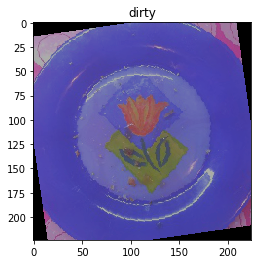

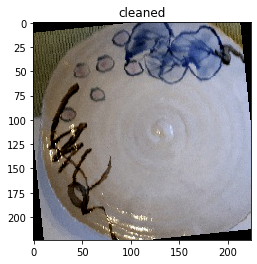

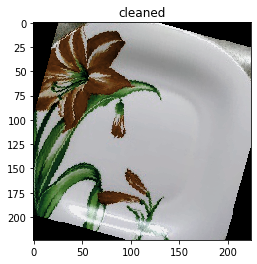

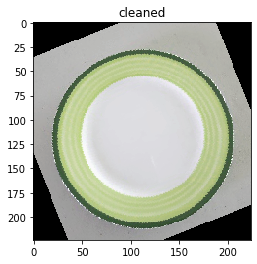

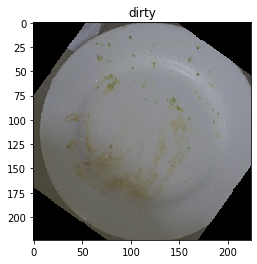

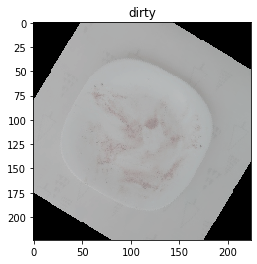

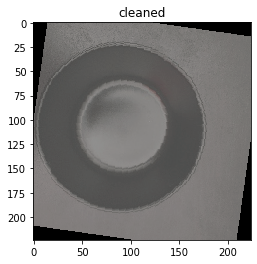

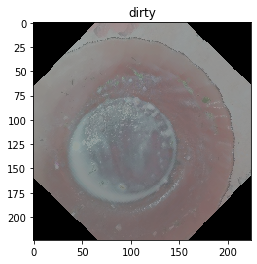

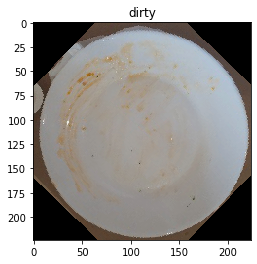

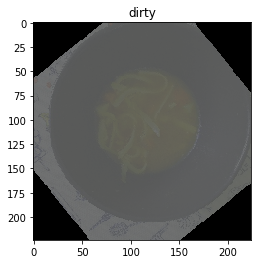

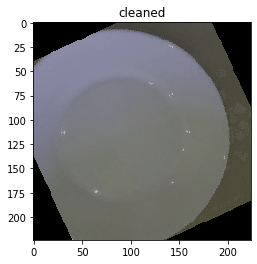

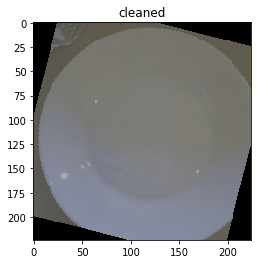

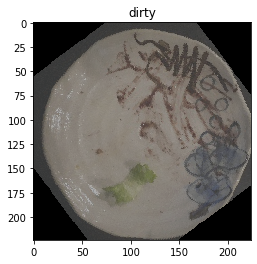

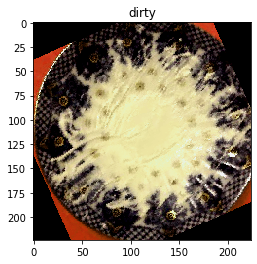

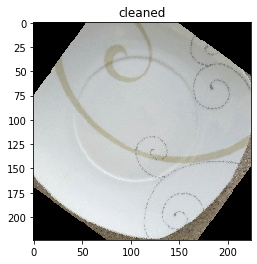

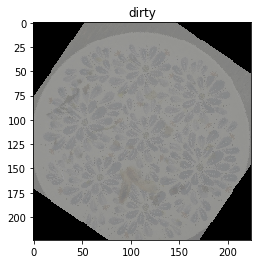

In [ ]:
config = {
    'batch_size': 16,
    'weight_decay': 0.005
}

data_root = os.path.join('drive/My Drive', 'data')
print(os.listdir(data_root))

train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'test')
class_names = ['cleaned', 'dirty']

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    # transforms.ColorJitter(0.5, 0.5, 0.0, 0.3),
    transforms.ColorJitter(*sample[1]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)
print(f"train: {len(train_dataset)}")
print(f"val: {len(test_dataset)}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)


def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
X_batch, y_batch = next(iter(train_dataloader))
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
print(dir(models))

['AlexNet', 'DenseNet', 'GoogLeNet', 'GoogLeNetOutputs', 'Inception3', 'InceptionOutputs', 'MNASNet', 'MobileNetV2', 'ResNet', 'ShuffleNetV2', 'SqueezeNet', 'VGG', '_GoogLeNetOutputs', '_InceptionOutputs', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'detection', 'googlenet', 'inception', 'inception_v3', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'quantization', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'segmentation', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'shufflenetv2', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'utils', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'video', 'wide_resnet101_2', 'wide_r

In [ ]:
def make_model():
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer4[-1].parameters():
        param.requires_grad = True

    model.fc = torch.nn.Sequential(*[
        torch.nn.Linear(model.fc.in_features, 300),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(300),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(300, 300),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(300),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(300, 2),
    ])
    return model

In [ ]:
# model = models.resnet10(pretrained=True) # 0.82
# model = models.resnet34(pretrained=True) # 0.61
# model = models.resnet50(pretrained=True) # 0.85
# model = models.resnet101(pretrained=True)  # 0.72
# model = models.resnet152(pretrained=True)  # 0.80

# Disable grad for all conv layers
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = torch.nn.Linear(model.fc.in_features, 2)

In [ ]:
# model = models.vgg16(pretrained=True)
# for param in list(model.children())[0].parameters():
#     param.requires_grad = False
    
# print(model)
# backbone = torch.nn.Sequential(*(list(model.children())[:-1]))
# ending = list(model.children())[-1]
# ending = torch.nn.Sequential(*( list(ending.children())[:-1] + [torch.nn.Linear(in_features= list(ending.children())[-1].in_features, out_features=2, bias=True)] ))
# newmodel = torch.nn.Sequential(backbone, ending)
# print(newmodel)

In [ ]:
# model = newmodel

# for param in list(model.children())[0].parameters():
#     param.requires_grad = False

In [ ]:
!pip install wandb
!wandb login  bcce9abce5fc466e16b95be09ed38b999ed644d0

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 460kB 16.3MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=3e42a746920f155e926f292d6ecf42843843c39e45c7355a992efc636737297d
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for shortuuid: filename=shortuuid-0.5.0-cp36-none-any.whl size=5497 sha256=783168852d9ba9eadc0285d4ce1d04df582ccd3c2e43e9b58cbd149c10631a40
  Stored in directory: /root/.cache/pip/wheels/3f/eb/fd/69e5177f67b505e44acbd1aedfbe44b91768ee0c4cd5636576
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=7360

In [ ]:
def get_next_i(path):
  temp = os.listdir(path)
  i_s = list(map(lambda x: int(x.split('.')[0].split('_')[1]), temp))
  if len(i_s) == 0:
    return 0
  return max(i_s)+1  

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

num_epochs = 100
test_period = 1

import wandb

models_path = os.path.join('drive/My Drive', 'data', 'models')
os.makedirs(models_path, exist_ok=True)
model_i = f'11_colojitter_tune_{sample[0]}' # get_next_i(models_path)
model_file_path = os.path.join(models_path, f'model_{model_i}')

wandb.init(project='resnet50', name=f'model_{model_i}')
wandb.config.path = model_file_path
wandb.config.seed = seed
wandb.config.optimizer = 'Adam 0.0005'
wandb.config.epochs = num_epochs
wandb.config.device = 'cpu'
wandb.config.comment = 'base-resnet50 centercrop flipVH + weight decay 0.01 + batchnorm + 300 hidden layer instead 500. unfreeze last bottleneck, '
wandb.config.numbers = config
wandb.config.colojitter = sample[1]




model = make_model()

device = torch.device("cpu") # ("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=config['weight_decay'])
# optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-3, momentum=0.0000)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)


# train_model



train_line = []
test_line = []
last_best_test_acc = None

try:
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase=='test' and (epoch==0 or epoch % test_period != 0):
                break
                
            if phase == 'train':
                dataloader = train_dataloader
                if epoch>0:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = test_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == 'train':
                wandb.log({'train_loss': epoch_loss, 'train_acc': epoch_acc}, step=epoch)
                train_line.append({'epoch': epoch,'loss': epoch_loss, 'acc': epoch_acc})
            else:
                if not last_best_test_acc or epoch_acc > last_best_test_acc:
                  torch.save(model.state_dict(), model_file_path)
                  wandb.config.update({'test_acc': epoch_acc, 'dump_epoch': epoch}, allow_val_change=True)
                wandb.log({'test_loss': epoch_loss, 'test_acc': epoch_acc}, step=epoch)
                test_line.append({'epoch': epoch,'loss': epoch_loss, 'acc': epoch_acc})

finally:
    plt.plot([p['epoch'] for p in train_line], [p['acc'] for p in train_line], label='train_acc')
    plt.plot([p['epoch'] for p in test_line], [p['acc'] for p in test_line], label='test_acc')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Epoch 0/99:
train Loss: 0.8732 Acc: 0.4583
Epoch 1/99:
train Loss: 0.3758 Acc: 0.8125
test Loss: 0.4363 Acc: 0.7673
Epoch 2/99:
train Loss: 0.3520 Acc: 0.8958
